This notebook descrbies the PORT-EK pipeline analysis of k-mers genreated from the "deer" dataset from [reference to our paper].
To use it you will need the k-mer indices generated with PORTEKfind.py in the output/deer/15mer_indices directory.
To generate the indices as in the paper, you will need to run PORTEKfind.py on the appropriate GISAID data sets, previously downloaded in fasta files, using the following commands from the main PORT-EK directory:
 - python PORTEKfind.py "input/deer/EPI_SET_240422va.fasta" "output/deer/15mer_indices/" --k 15 --group deer
 - python PORTEKfind.py "input/deer/EPI_SET_240422rw.fasta" "output/deer/15mer_indices/" --k 15 --group humearly  
 - python PORTEKfind.py "input/deer/EPI_SET_240422qc.fasta" "output/deer/15mer_indices/" --k 15 --group humlate  

For the selection of optimal k please see optimal_deer_k_selection.ipynb notebook. 
Note that GISAID web interface only allows downloading up to 10 000 sequences in one file, so when you download the 04.2021 and 11.2021 human viral sequences (data sets EPI_SET_240422rw and EPI_SET_240422qc) they will be in several files. You have to first combine them into a single fasta file or run PORTEKfind separately on the partial files. 


1. Import necessary libraries and PORT-EK source code:

In [173]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pathlib
import pickle
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO, Align

#adding portek source directory to sys path before importing
portek_path = "../portek"
sys.path.insert(0,portek_path)
import portek

pd.options.mode.copy_on_write = True
print(os.getpid())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1009075


2. Declare data set specific definitions and functions:

In [108]:
# PORT-EK parameters
k = 15 # This is the kmer length.
c = 0.01  # This is the conservation thershold used in k-mer rarity filter
m = 2  # This is the maximum number of mismatches allowed when re-examining rare k-mers
min_RMSE = 0.1  # This is the RMSE threshold used to select enriched k-mers
m_map = 2  # This is the maximum number of mismatches allowed when mapping k-mers to reference genome
l_map = 1000  # This the maximum allowed offset of mapping position from average position of k-mer in samples

# Relative path to k-mer indices
INPUT_PATH = f"../output/deer/"

# Data set specific definitions of k-mer type, column names, reference gene and protein mapping, and colors for plots.

FREQ_COLS = ["deer_freq", "humearly_freq", "humlate_freq"]
AVG_COLS = ["deer_avg", "humearly_avg", "humlate_avg"]

VOLCANO_CMAP = {
    "not significant": ("#DDDDDD", 0.5),
    "deer over-represented": ("#ffa401", 1),
    "human over-represented": ("#005ff5", 1),
    "time-dependant": ("#b99e9e", 0.8),
}
GENE_ORDER_LIST = [
    "orf1ab",
    "S",
    "orf3a",
    "E",
    "M",
    "orf6",
    "orf7a",
    "orf7b",
    "orf8",
    "N",
    "orf10",
    "intergenic",
]
PROTEIN_ORDER_LIST = [
    "nsp1",
    "nsp2",
    "nsp3",
    "nsp4",
    "nsp5",
    "nsp6",
    "nsp7",
    "nsp8",
    "nsp9",
    "nsp10",
    "nsp12",
    "nsp13",
    "nsp14",
    "nsp15",
    "nsp16",
    "S",
    "orf3a",
    "E",
    "M",
    "orf6",
    "orf7a",
    "orf7b",
    "orf8",
    "N",
    "orf10",
    "non-coding",
]


def assign_kmer_type(row):
    if (
        row["deer_early_err"] > 0
        and row["deer_late_err"] > 0
        and row["p-value_late"] < 0.01
        and row["p-value_early"] < 0.01
    ):
        return "deer over-represented"
    elif (
        row["deer_early_err"] < 0
        and row["deer_late_err"] < 0
        and row["p-value_late"] < 0.01
        and row["p-value_early"] < 0.01
    ):
        return "human over-represented"
    elif row["p-value_early"] < 0.01 or row["p-value_late"] < 0.01:
        return "time-dependant"
    else:
        return "not significant"


def assign_gene(pos):
    if pos in range(266, 21555 + 1):
        gene = "orf1ab"
    elif pos in range(21563, 25384 + 1):
        gene = "S"
    elif pos in range(25393, 26220 + 1):
        gene = "orf3a"
    elif pos in range(26245, 26472 + 1):
        gene = "E"
    elif pos in range(26523, 27191 + 1):
        gene = "M"
    elif pos in range(27202, 27387 + 1):
        gene = "orf6"
    elif pos in range(27394, 27759 + 1):
        gene = "orf7a"
    elif pos in range(27756, 27887 + 1):
        gene = "orf7b"
    elif pos in range(27894, 28259 + 1):
        gene = "orf8"
    elif pos in range(28274, 29533 + 1):
        gene = "N"
    elif pos in range(29558, 29674 + 1):
        gene = "orf10"
    else:
        gene = "intergenic"
    return gene


def assign_protein(pos):
    if pos in range(266, 805 + 1):
        protein = "nsp1"
    elif pos in range(806, 2719 + 1):
        protein = "nsp2"
    elif pos in range(2720, 8554 + 1):
        protein = "nsp3"
    elif pos in range(8555, 10054 + 1):
        protein = "nsp4"
    elif pos in range(10055, 10972 + 1):
        protein = "nsp5"
    elif pos in range(10973, 11842 + 1):
        protein = "nsp6"
    elif pos in range(11843, 12091 + 1):
        protein = "nsp7"
    elif pos in range(12092, 12685 + 1):
        protein = "nsp8"
    elif pos in range(12686, 13024 + 1):
        protein = "nsp9"
    elif pos in range(13025, 13441 + 1):
        protein = "nsp10"
    elif pos in range(13442, 16236 + 1):
        protein = "nsp12"
    elif pos in range(16237, 18039 + 1):
        protein = "nsp13"
    elif pos in range(18040, 19620 + 1):
        protein = "nsp14"
    elif pos in range(19621, 20658 + 1):
        protein = "nsp15"
    elif pos in range(20659, 21555 + 1):
        protein = "nsp16"
    elif pos in range(21563, 25384 + 1):
        protein = "S"
    elif pos in range(25393, 26220 + 1):
        protein = "orf3a"
    elif pos in range(26245, 26472 + 1):
        protein = "E"
    elif pos in range(26523, 27191 + 1):
        protein = "M"
    elif pos in range(27202, 27387 + 1):
        protein = "orf6"
    elif pos in range(27394, 27759 + 1):
        protein = "orf7a"
    elif pos in range(27756, 27887 + 1):
        protein = "orf7b"
    elif pos in range(27894, 28259 + 1):
        protein = "orf8"
    elif pos in range(28274, 29533 + 1):
        protein = "N"
    elif pos in range(29558, 29674 + 1):
        protein = "orf10"
    else:
        protein = "non-coding"
    return protein

def encode_kmer(kmer_seq: str) -> int:
    encoding_dict = {"A":"00","C":"01","G":"10","T":"11"}
    kmer_bin_string = [encoding_dict[nuc] for nuc in kmer_seq]
    id = int("".join(kmer_bin_string), base=2)
    return id


def decode_kmer(id: int, k) -> str:
    decoding = {"00":"A", "01":"C","10":"G","11":"T"}
    kmer_bin_string = bin(id)[2:].rjust(2*k, "0")
    kmer_bin_string = [kmer_bin_string[i:i+2] for i in range(0, len(kmer_bin_string),2)]
    kmer_seq = "".join([decoding[bits] for bits in kmer_bin_string])
    return kmer_seq

3. Construct k-mer count matrix and apply rarity filter

In [109]:
# First read all sample labels and k-mer sequences and construct an empty matrix. It requires significantly less memory than updating the table one-by-one.
kmer_set = set()
sample_list = []
kmer_set_in_path = pathlib.Path(INPUT_PATH).glob(f"*{k}mer_set.pkl")
sample_list_in_path = pathlib.Path(INPUT_PATH).glob("*sample_list.pkl")

for filename in kmer_set_in_path:
    with open(filename, mode="rb") as in_file:
        partial_set = pickle.load(in_file)
    kmer_set.update(partial_set)

for filename in sample_list_in_path:
    with open(filename, mode="rb") as in_file:
        partial_list = pickle.load(in_file)
    group = filename.stem.split("_")[0]
    partial_list = [f"{group}_{sample_name}" for sample_name in partial_list]
    sample_list.extend(partial_list)

all_kmer_matrix = pd.DataFrame(
    0, index=list(kmer_set), columns=sample_list, dtype="uint8"
)
deer_sample_idx = [sample for sample in all_kmer_matrix.columns if "deer" in sample]
humearly_sample_idx = [
    sample for sample in all_kmer_matrix.columns if "humearly" in sample
]
humlate_sample_idx = [
    sample for sample in all_kmer_matrix.columns if "humlate" in sample
]

print(f"\nImported {len(kmer_set)} kmers and {len(sample_list)} samples.")

# Next, fill the table with k-mer counts.
counter = 1
tot_files = len(sample_list)
in_path = pathlib.Path(f"{INPUT_PATH}/{k}mer_indices").glob("*_count.pkl")

for filename in in_path:
    with open(filename, mode="rb") as in_file:
        temp_dict = pickle.load(in_file)
    sample_name = "_".join(filename.stem.split("_")[:-1])
    count_dict = {f"{sample_name}": temp_dict.values()}
    temp_df = pd.DataFrame(count_dict, index=temp_dict.keys(), dtype="uint8")
    all_kmer_matrix.update(temp_df)
    print(
        f"Completed {filename.stem}. {counter} of {tot_files} indices done.",
        end="\r",
        flush=True,
    )
    counter += 1

# Decode k-mer sequences
all_kmer_matrix.index = all_kmer_matrix.index.map(lambda id: decode_kmer(id,k))

# Construct a temporary binary count matrix, i.e. one that shows if a k-mer is present in sequence, without regards to actual count.
# Calculate k-mer frequencies and average counts in host groups.
bin_kmer_matrix = all_kmer_matrix > 0
all_kmer_matrix["deer_freq"] = bin_kmer_matrix.loc[:, deer_sample_idx].mean(axis=1)
all_kmer_matrix["humearly_freq"] = bin_kmer_matrix.loc[:, humearly_sample_idx].mean(
    axis=1
)
all_kmer_matrix["humlate_freq"] = bin_kmer_matrix.loc[:, humlate_sample_idx].mean(
    axis=1
)
all_kmer_matrix["deer_avg"] = all_kmer_matrix.loc[:, deer_sample_idx].mean(axis=1)
all_kmer_matrix["humearly_avg"] = all_kmer_matrix.loc[:, humearly_sample_idx].mean(
    axis=1
)
all_kmer_matrix["humlate_avg"] = all_kmer_matrix.loc[:, humlate_sample_idx].mean(axis=1)
del bin_kmer_matrix

# Remove polyA, as it's presence and count is mostly dependant on sequencing quality not viral variant.
if "AAAAAAAAAAAAAAA" in all_kmer_matrix.index:
    all_kmer_matrix = all_kmer_matrix.drop("AAAAAAAAAAAAAAA")

# Apply rarity filter.
common_kmer_matrix = portek.filter_kmers(
    all_kmer_matrix, freq_cols=FREQ_COLS, cons_thr=c
)

print(
    f"\n{len(common_kmer_matrix)} common k-mers remaining after filtering at a threshold of {c}."
)


Imported 371342 kmers and 33767 samples.
Completed humlate_EPI_ISL_7308194_count. 33767 of 33767 indices done...
41946 common k-mers remaining after filtering at a threshold of 0.01.


4. Calculate common k-mer statistics and identify host over-represented k-mers.

In [4]:
# Calculate mean k-mer count change, RMSE and test statistical significance.
common_kmer_matrix["deer_early_err"] = (
    common_kmer_matrix["deer_avg"] - common_kmer_matrix["humearly_avg"]
)
common_kmer_matrix["deer_late_err"] = (
    common_kmer_matrix["deer_avg"] - common_kmer_matrix["humlate_avg"]
)
common_kmer_matrix["deer_RMSE"] = np.sqrt(
    (
        (common_kmer_matrix["deer_early_err"]) ** 2
        + (common_kmer_matrix["deer_late_err"]) ** 2
    )
    / 2
)
common_kmer_matrix["seq"] = common_kmer_matrix.index
common_kmer_matrix["p-value_early"] = common_kmer_matrix["seq"].apply(
    portek.calc_kmer_pvalue,
    args=(deer_sample_idx, humearly_sample_idx, common_kmer_matrix),
)
common_kmer_matrix["p-value_late"] = common_kmer_matrix["seq"].apply(
    portek.calc_kmer_pvalue,
    args=(deer_sample_idx, humlate_sample_idx, common_kmer_matrix),
)
common_kmer_matrix = common_kmer_matrix.sort_values("deer_RMSE", ascending=False)
common_kmer_matrix = common_kmer_matrix.drop("seq", axis=1)
common_kmer_matrix["-log10_p-value_early"] = -np.log10(
    common_kmer_matrix["p-value_early"]
)
common_kmer_matrix["-log10_p-value_late"] = -np.log10(
    common_kmer_matrix["p-value_late"]
)

# Identify host-overrepresented k-mers, according to the statistics calculated above.
common_kmer_matrix["group"] = common_kmer_matrix.apply(assign_kmer_type, axis=1)

# Make a separate DataFrame with just the statistics, without counts, for export and analysis.
common_kmer_stat_matrix = common_kmer_matrix.drop(sample_list, axis=1)

# Record over-represented k-mers in separate DataFrames
deer_overrep = common_kmer_matrix[
    common_kmer_matrix["group"] == "deer over-represented"
]
human_overrep = common_kmer_matrix[
    common_kmer_matrix["group"] == "human over-represented"
]

/home/labadmin/repos/PORT-EK 2/env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Optional: save/load k-mer count and statistics matrices. Uncomment the relevant lines to save/load particular files.

In [5]:
# common_kmer_matrix.to_csv(f"../output/deer/common_{k}mer_count_matrix.csv")
common_kmer_stat_matrix.to_csv(f"../output/deer/common_{k}mer_stat_matrix.csv")
# all_kmer_matrix.to_csv(f"../output/deer/all_{k}mer_count_matrix.csv")

# common_kmer_matrix = pd.read_csv(f'../output/deer/common_{k}mer_count_matrix.csv', index_col=0)
# all_kmer_matrix = pd.read_csv(f'../output/deer/all_{k}mer_count_matrix.csv', index_col=0)
# common_kmer_stat_matrix = pd.read_csv(f"../output/deer/common_{k}mer_stat_matrix.csv", index_col=0)

5. Visualize common k-mers using volcano plots. Uncomment the last line in each cell to save as svg.

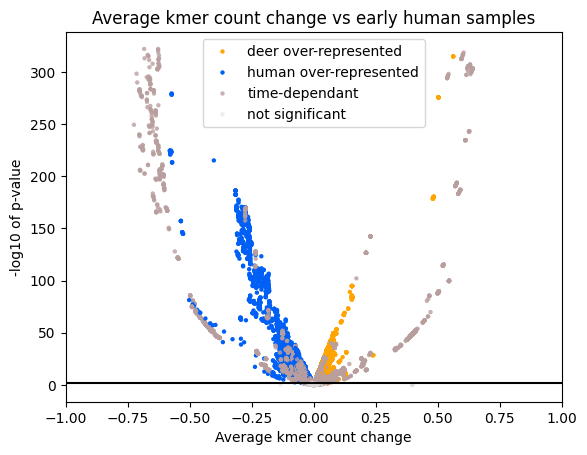

In [6]:
fig, ax = plt.subplots()
plt.axhline(y=-np.log10(0.01), color = 'black')
ax.set_xlim(-1,1)
ax.set_title('Average kmer count change vs early human samples')
ax.set_xlabel('Average kmer count change')
ax.set_ylabel('-log10 of p-value')
sns.scatterplot(data=common_kmer_matrix, x='deer_early_err', y = '-log10_p-value_early', s=10, linewidth = 0, hue='group', palette=VOLCANO_CMAP)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()

# plt.savefig(f"../output/deer/deer_{k}mers_change_vs_p_early.svg", dpi = 600, format = "svg")

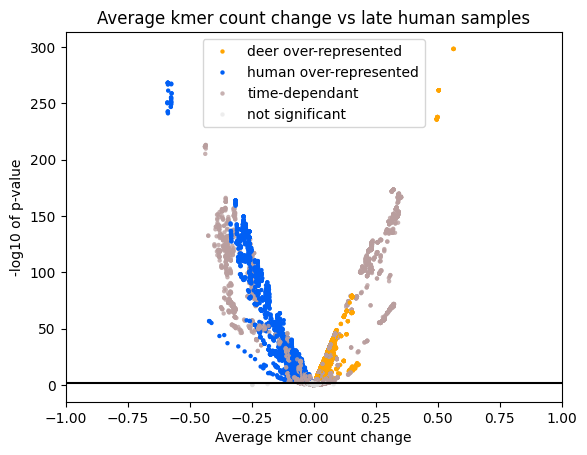

In [7]:
fig, ax = plt.subplots()
plt.axhline(y=-np.log10(0.01), color = 'black')
ax.set_xlim(-1,1)
ax.set_title('Average kmer count change vs late human samples')
ax.set_xlabel('Average kmer count change')
ax.set_ylabel('-log10 of p-value')
sns.scatterplot(data=common_kmer_matrix, x='deer_late_err', y = '-log10_p-value_late',s=10, linewidth = 0, hue='group', palette=VOLCANO_CMAP)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()

# plt.savefig(f"../output/deer/deer_{f}mers_change_vs_p_late.svg", dpi = 600, format = "svg")

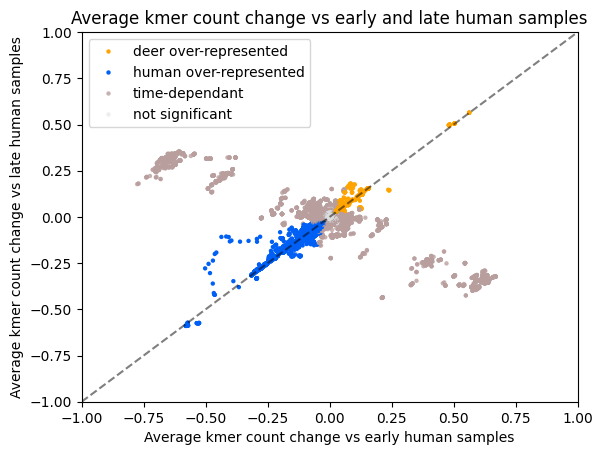

In [8]:
fig, ax = plt.subplots()
plt.axline((0, 0), slope=1, color=("black",0.5), linestyle="dashed")
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_title('Average kmer count change vs early and late human samples')
ax.set_xlabel('Average kmer count change vs early human samples')
ax.set_ylabel('Average kmer count change vs late human samples')
sns.scatterplot(data = common_kmer_matrix, x='deer_early_err', y='deer_late_err',s=10, linewidth = 0, hue='group', palette = VOLCANO_CMAP)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0,2,3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()

# plt.savefig("../output/deer/change_corr.svg", dpi = 600, format = "svg")

6. Optionally re-examin rare k-mers similar to over-represented k-mers. Run the two cells below only if you want to include potential rare, but still enriched k-mers in the analysis.

In [9]:
# Select all rare k-mers that have higher average count in deer, no matter the statistical significance.
deer_overrep_rare = all_kmer_matrix.loc[
    (all_kmer_matrix["deer_avg"] == all_kmer_matrix[AVG_COLS].max(axis=1))
]
deer_overrep_rare = deer_overrep_rare[~deer_overrep_rare.index.isin(deer_overrep.index)]

# Comment the following line to avoid lengthy k-mer similarity graph calculation
deer_overrep_similarity_graph = portek.build_similarity_graph_two_list(
    deer_overrep.index.tolist(), deer_overrep_rare.index.tolist(), m
)

# Uncomment the first of the following blocks to save the graph as pickle file. Uncomment the second to load a previously calculated graph.

with open(f"../output/deer/dor_{k}mer_{m}m.pickle", mode = "wb") as out_file:
    pickle.dump(deer_overrep_similarity_graph, out_file)

# with open(f"../output/deer/dor_{k}mer_{m}m.pickle", mode = "rb") as in_file:
#     deer_overrep_similarity_graph = pickle.load(in_file)

# Discard rare k-mers that are not in the similarity graph.
deer_overrep_rare = deer_overrep_rare[
    deer_overrep_rare.index.isin(deer_overrep_similarity_graph.nodes)
]

# Calculate statistics and significance for rare k-mers similar to bat over-represented k-mers and choose the significant ones.
# Calculation is identical to the one done for common k-mers.
deer_overrep_rare["deer_early_err"] = (
    deer_overrep_rare["deer_avg"] - deer_overrep_rare["humearly_avg"]
)
deer_overrep_rare["deer_late_err"] = (
    deer_overrep_rare["deer_avg"] - deer_overrep_rare["humlate_avg"]
)
deer_overrep_rare["deer_RMSE"] = np.sqrt(
    (
        (deer_overrep_rare["deer_early_err"]) ** 2
        + (deer_overrep_rare["deer_late_err"]) ** 2
    )
    / 2
)
deer_overrep_rare["seq"] = deer_overrep_rare.index
deer_overrep_rare["p-value_early"] = deer_overrep_rare["seq"].apply(
    portek.calc_kmer_pvalue,
    args=(deer_sample_idx, humearly_sample_idx, deer_overrep_rare),
)
deer_overrep_rare["p-value_late"] = deer_overrep_rare["seq"].apply(
    portek.calc_kmer_pvalue,
    args=(deer_sample_idx, humlate_sample_idx, deer_overrep_rare),
)
deer_overrep_rare = deer_overrep_rare.sort_values("deer_RMSE", ascending=False)
deer_overrep_rare = deer_overrep_rare.drop("seq", axis=1)
deer_overrep_rare["-log10_p-value_early"] = -np.log10(
    deer_overrep_rare["p-value_early"]
)
deer_overrep_rare["-log10_p-value_late"] = -np.log10(deer_overrep_rare["p-value_late"])
deer_overrep_rare["group"] = deer_overrep_rare.apply(assign_kmer_type, axis=1)
deer_overrep_rare = deer_overrep_rare[
    deer_overrep_rare["group"] == "deer over-represented"
]
deer_overrep_all = pd.concat([deer_overrep_rare, deer_overrep])

In [10]:
# See cell above for explanation. This cell has the same calculations, but done on human over-represented k-mers.
human_overrep_rare = all_kmer_matrix.loc[
    (all_kmer_matrix["deer_avg"] == all_kmer_matrix[AVG_COLS].min(axis=1))
]
human_overrep_rare = human_overrep_rare[
    ~human_overrep_rare.index.isin(human_overrep.index)
]

# Comment the following line to avoid lengthy k-mer similarity graph calculation
human_overrep_similarity_graph = portek.build_similarity_graph_two_list(
    human_overrep.index.tolist(), human_overrep_rare.index.tolist(), m
)

# Uncomment the first of the following blocks to save the graph as pickle file. Uncomment the second to load a previously calculated graph.

with open(f"../output/deer/hor_{k}mer_{m}m.pickle", mode = "wb") as out_file:
    pickle.dump(human_overrep_similarity_graph, out_file)

# with open(f"../output/deer/hor_{k}mer_{m}m.pickle", mode = "rb") as in_file:
#     human_overrep_similarity_graph = pickle.load(in_file)

human_overrep_rare = human_overrep_rare[
    human_overrep_rare.index.isin(human_overrep_similarity_graph.nodes)
]

human_overrep_rare["deer_early_err"] = (
    human_overrep_rare["deer_avg"] - human_overrep_rare["humearly_avg"]
)
human_overrep_rare["deer_late_err"] = (
    human_overrep_rare["deer_avg"] - human_overrep_rare["humlate_avg"]
)
human_overrep_rare["deer_RMSE"] = np.sqrt(
    (
        (human_overrep_rare["deer_early_err"]) ** 2
        + (human_overrep_rare["deer_late_err"]) ** 2
    )
    / 2
)
human_overrep_rare["seq"] = human_overrep_rare.index
human_overrep_rare["p-value_early"] = human_overrep_rare["seq"].apply(
    portek.calc_kmer_pvalue,
    args=(deer_sample_idx, humearly_sample_idx, human_overrep_rare),
)
human_overrep_rare["p-value_late"] = human_overrep_rare["seq"].apply(
    portek.calc_kmer_pvalue,
    args=(deer_sample_idx, humlate_sample_idx, human_overrep_rare),
)
human_overrep_rare = human_overrep_rare.sort_values("deer_RMSE", ascending=False)
human_overrep_rare = human_overrep_rare.drop("seq", axis=1)
human_overrep_rare["-log10_p-value_early"] = -np.log10(
    human_overrep_rare["p-value_early"]
)
human_overrep_rare["-log10_p-value_late"] = -np.log10(
    human_overrep_rare["p-value_late"]
)
human_overrep_rare["group"] = human_overrep_rare.apply(assign_kmer_type, axis=1)
human_overrep_rare = human_overrep_rare[
    human_overrep_rare["group"] == "human over-represented"
]
human_overrep_all = pd.concat([human_overrep_rare, human_overrep])

7. Find enriched k-mers by applying the RMSE filter. Export enriched k-mers for use in host classification.

In [11]:
# Take the over-represented k-mers that pass the RMSE filter. This generates of enriched k-mers identified by PORT-EK.

# Uncomment this block if you didn't re-examine the rare k-mers.
# deer_enriched = deer_overrep[deer_overrep["deer_RMSE"] > min_RMSE]
# human_enriched = human_overrep[human_overrep["deer_RMSE"] > min_RMSE]

# Comment this block if you didn't re-examine the rare k-mers.
deer_enriched = deer_overrep_all[deer_overrep_all['deer_RMSE']>min_RMSE]
human_enriched = human_overrep_all[human_overrep_all['deer_RMSE']>min_RMSE]

del all_kmer_matrix
enriched_kmer_matrix = pd.concat([deer_enriched, human_enriched])
enriched_kmer_stat_martix = enriched_kmer_matrix.drop(sample_list, axis=1)

print(
    f"{len(deer_enriched)} bat enriched k-mers and {len(human_enriched)} human enriched k-mers found."
)


def assign_host_numerical(sample_id):
    if sample_id in deer_sample_idx:
        host = 1
    else:
        host = 0
    return host


# Prepare and save count matrix with host labels for use by classifiers that predict the most probalbe host of a viral sequence.
counts_for_classifier = enriched_kmer_matrix.T
counts_for_classifier.drop(common_kmer_stat_matrix.columns.difference(['group']), axis=0, inplace=True)
counts_for_classifier['host'] = counts_for_classifier.index.map(assign_host_numerical)

counts_for_classifier.to_csv(f"../output/deer/{k}mer_counts_for_classifier.csv")
enriched_kmer_stat_martix.to_csv(f"../output/deer/enriched_{k}mer_stat_martix.csv")

146 bat enriched k-mers and 1324 human enriched k-mers found.


8. Map enriched k-mers to the reference genome and identify host-enriched mutations.

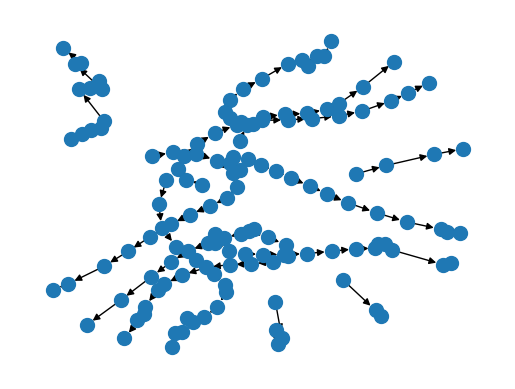

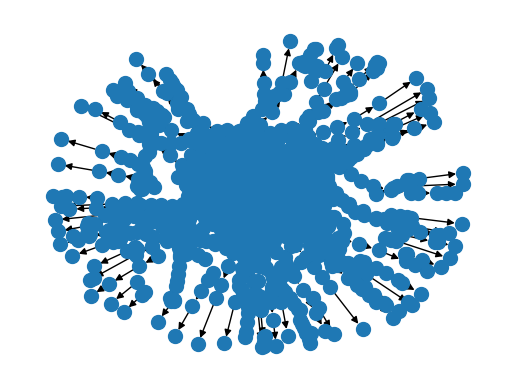

In [187]:
deer_enriched_graph = portek.assemble_kmers(deer_enriched.index)
human_enriched_graph = portek.assemble_kmers(human_enriched.index)
fig,ax=plt.subplots()
nx.draw(deer_enriched_graph, node_size=100, ax=ax)
fig,ax=plt.subplots()
nx.draw(human_enriched_graph, node_size=100, ax=ax)

In [230]:
assemblies = [deer_enriched_graph.subgraph(c).copy() for c in nx.weakly_connected_components(deer_enriched_graph)]
contigs = {"type":[],"seq":[],"len":[]}

for assembly in assemblies:
    if nx.is_directed_acyclic_graph(assembly) == True:
        sources = [node for node in assembly.nodes if assembly.in_degree(node) == 0]
        targets = [node for node in assembly.nodes if assembly.out_degree(node) == 0]
        if len(sources) == 1:
            paths = []
            for target in targets:
                paths.extend(list(nx.all_simple_paths(assembly, sources[0], target)))
            for path in paths:
                contigs["type"].append("deer_enriched")
                seq = "".join([path[0]] + [kmer[-1] for kmer in path[1:]])
                contigs["seq"].append(seq)
                contigs["len"].append(len(seq))


assemblies = [human_enriched_graph.subgraph(c).copy() for c in nx.weakly_connected_components(human_enriched_graph)]
for assembly in assemblies:
    if nx.is_directed_acyclic_graph(assembly) == True:
        sources = [node for node in assembly.nodes if assembly.in_degree(node) == 0]
        targets = [node for node in assembly.nodes if assembly.out_degree(node) == 0]
        if len(sources) == 1:
            paths = []
            for target in targets:
                paths.extend(list(nx.all_simple_paths(assembly, sources[0], target)))
            for path in paths:
                contigs["type"].append("human_enriched")
                seq = "".join([path[0]] + [kmer[-1] for kmer in path[1:]])
                contigs["seq"].append(seq)
                contigs["len"].append(len(seq))
        
contigs = pd.DataFrame(contigs)
contigs

Found 13 deer enriched variants.
Found 70 human enriched variants.


,type,seq,len
0,deer_enriched,TTTTTTTTTTATGAAAATGCCTT,23
1,deer_enriched,ATGGAAATTGATTTTTTAGAATTAGCTAT,29
2,deer_enriched,TCACATAGCAATTTTTAATCAGTGTGT,27
3,deer_enriched,ATTAGTGCAAAGAACAGAGCTCGCACCGT,29
4,deer_enriched,GAAGAAATGCTGGATAA,17
...,...,...,...
78,human_enriched,TTGGTAGATTTGCCAATA,18
79,human_enriched,ACATACGAGGGCAATT,16
80,human_enriched,AACTCTACTAATGTCAC,17
81,human_enriched,GATTTTCAAGAAAACTG,17


In [231]:
ref_seq = SeqIO.read("../input/wuhan1_ref.fasta", format="fasta").seq
aligner = Align.PairwiseAligner(match_score = 5, mismatch_score = -4, open_gap_score = -10, extend_gap_score = -0.5, mode="local")
starts = []
ends = []
matches = []

for i in range(len(contigs)):
    alns = aligner.align(ref_seq, contigs.loc[i,"seq"])
    if len(alns) == 1:
        for aln in alns:
            matches.append(aln.counts()[1])
            starts.append(aln.indices[0][0]+1)
            ends.append(aln.indices[0][-1]+1)
    else:
        starts.append(-1)
        ends.append(-1)
        matches.append(0)

contigs["ref_start"] = starts
contigs["ref_end"] = ends
contigs["matches"] = matches

deer_seq = list(SeqIO.parse("../input/deer/EPI_SET_240422va.fasta", format = "fasta"))

tot_seq = len(deer_seq)
real_deer_freqs = []
for i in range(len(contigs)):
    pos_seq = 0
    for seq in deer_seq:
        if contigs.loc[i, "seq"] in seq:
            pos_seq += 1
    real_deer_freqs.append(pos_seq/tot_seq)
contigs["deer_real_freq"] = real_deer_freqs

humearly_seq = list(SeqIO.parse("../input/deer/EPI_SET_240422rw.fasta", format = "fasta"))

tot_seq = len(humearly_seq)
real_humearly_freqs = []
for i in range(len(contigs)):
    pos_seq = 0
    for seq in humearly_seq:
        if contigs.loc[i, "seq"] in seq:
            pos_seq += 1
    real_humearly_freqs.append(pos_seq/tot_seq)
contigs["humearly_real_freq"] = real_humearly_freqs

humalte_seq = list(SeqIO.parse("../input/deer/EPI_SET_240422qc.fasta", format = "fasta"))

tot_seq = len(humalte_seq)
real_humalte_freqs = []
for i in range(len(contigs)):
    pos_seq = 0
    for seq in humalte_seq:
        if contigs.loc[i, "seq"] in seq:
            pos_seq += 1
    real_humalte_freqs.append(pos_seq/tot_seq)
contigs["humlate_real_freq"] = real_humalte_freqs

In [237]:
contigs["RMSE"] = np.sqrt(
    (
        (contigs["deer_real_freq"] - contigs["humearly_real_freq"]) ** 2
        + (contigs["deer_real_freq"] - contigs["humlate_real_freq"]) ** 2
    )
    / 2
)
contigs.sort_values("RMSE", ascending=False).head(10)

,type,seq,len,ref_start,ref_end,matches,deer_real_freq,humearly_real_freq,humlate_real_freq,RMSE
72,human_enriched,GGTATTGTAGCTATCGTAGTAACATGCCT,29,9416,9444,29,0.398810,0.972884,0.983774,0.579545
58,human_enriched,GGATTGGCTGCAATCATGCAATTGTTTTT,29,7289,7317,29,0.413690,0.943166,0.988807,0.552767
8,deer_enriched,GGATTGGCTGCAATTATGCAATTGTTTTT,29,7289,7317,28,0.505952,0.002785,0.001475,0.503823
6,deer_enriched,GGTATTGTAGCTATTGTAGTAACATGCCT,29,9416,9444,28,0.500000,0.018945,0.003818,0.488677
43,human_enriched,TAGTTAACTTTAATCTCACATAGCAATCTTTAATCAGTGTGT,42,29652,29693,42,0.616071,0.981375,0.942473,0.346399
19,human_enriched,TGTAGATGCTGCTAAAGCTTACAAAGATTATCTAGCTAGTGGGGGA...,79,13084,13162,79,0.663690,0.988770,0.987158,0.324275
14,human_enriched,CAAGTCATCGTCAACAACCTAGACAAATCAGCTGGTTTTCCATTTA...,84,14914,14997,84,0.666667,0.993244,0.984729,0.322348
22,human_enriched,CACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGT...,52,24157,24208,52,0.574405,0.993883,0.724599,0.315056
34,human_enriched,TTAATAGGGGCTGAACATGTCAACAACTCATATGAGTGTGACATAC...,80,23510,23589,80,0.642857,0.945312,0.966508,0.313232
17,human_enriched,CTTCTGGTAATCTATTACTAGATAAACGCACTACGTGCTTTTCAGT...,88,14588,14675,88,0.693452,0.991098,0.985597,0.294908


In [235]:
enriched_kmer_stat_martix.loc["TTGTAGATCTGTTCT"]

deer_freq                            0.946429
humearly_freq                        0.702958
humlate_freq                         0.803037
deer_avg                             0.946429
humearly_avg                         0.707523
humlate_avg                          0.803037
deer_early_err                       0.238906
deer_late_err                        0.143392
deer_RMSE                            0.197024
p-value_early                             0.0
p-value_late                              0.0
-log10_p-value_early                28.376846
-log10_p-value_late                 12.956722
group                   deer over-represented
Name: TTGTAGATCTGTTCT, dtype: object